In [1]:
# Eval can start anywhere from left to goal state, vel 0 (also training). They need 71 episodes
# Modify cartpole to only have two actions-> left and right. The magnitude of the actions are much larger in nfq paper
# Need to do hint to goal
# Do this on pendulum too

In [2]:
import configargparse
import torch
import torch.optim as optim
import sys
sys.path.append('../')

from environments import MountainCarEnv, Continuous_MountainCarEnv
from models.agents import NFQAgent
from models.networks import NFQNetwork, ContrastiveNFQNetwork
from util import get_logger, close_logger, load_models, make_reproducible, save_models
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
import tqdm

In [3]:
def generate_data(init_experience=100, bg_only=False, continuous=False, agent=None, dataset='train'):
    if continuous:
        env_bg = Continuous_MountainCarEnv(group=0)
        env_fg = Continuous_MountainCarEnv(group=1)
    else:
        env_bg = MountainCarEnv(group=0)
        env_fg = MountainCarEnv(group=1)
    bg_rollouts = []
    fg_rollouts = []
    if init_experience > 0:
        for _ in range(init_experience):
            rollout_bg, episode_cost = env_bg.generate_rollout(
                agent, render=False, group=0, dataset=dataset
            )
            bg_rollouts.extend(rollout_bg)
            if not bg_only:
                rollout_fg, episode_cost = env_fg.generate_rollout(
                    agent, render=False, group=1, dataset=dataset
                )
                fg_rollouts.extend(rollout_fg)
    bg_rollouts.extend(fg_rollouts)
    all_rollouts = bg_rollouts.copy()
    return all_rollouts, env_bg, env_fg

In [4]:
env_bg = MountainCarEnv(group=0)
env_bg.action_space.sample()

0

# Continuous Mountaincar
* There are quite a few actions. This makes it hard for FQI to learn to succeed on this task. 

# Regular Mountaincar
* Has three actions, easier for FQI to understand what's going on. 

## Using random actions to generate rollout results in the agent never succeeding

/home/amandyam/.conda/envs/research/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

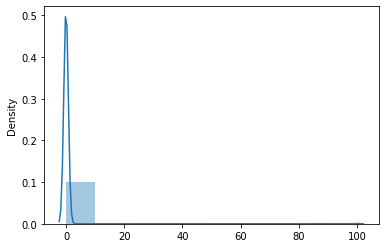

In [5]:
train_rollouts, train_env_bg, train_env_fg = generate_data(bg_only=True, continuous=False)
rewards = [r[2] for r in train_rollouts]
actions = [r[1] for r in train_rollouts]
sns.distplot(rewards, bins=10)

## Use a model to generate actions that are better than random
* This doesn't do well either without any adjustments. The model can't really learn how to make it past -0.4 position
* Even if we change the reward to be continuous, FQI can't learn it.
* However, we can make the reset speed 0.3, we sometimes learn it. 
* When we train a model, the reset has a speed of 0. 

## Train a new network with the result of better rollouts
* The evaluation is just changed to be regular resets (speed 0). 
* It doesn't really work. Even with the better 

In [9]:
train_rollouts, train_env_bg, train_env_fg = generate_data(init_experience=200, bg_only=True, continuous=False)
test_rollouts, eval_env_bg, eval_env_fg = generate_data(init_experience=200, bg_only=True, continuous=False, agent=nfq_agent, dataset='eval')
is_contrastive=False
epoch = 1000
nfq_net = ContrastiveNFQNetwork(
    state_dim=train_env_bg.state_dim, is_contrastive=is_contrastive, deep=False
)
optimizer = optim.Adam(nfq_net.parameters(), lr=1e-1)

nfq_agent = NFQAgent(nfq_net, optimizer)

bg_success_queue = [0] * 3
fg_success_queue = [0] * 3
epochs_fg = 0
eval_fg = 0
evaluations = 5
for k, ep in enumerate(tqdm.tqdm(range(epoch + 1))):
    state_action_b, target_q_values, groups = nfq_agent.generate_pattern_set(train_rollouts)

    if not nfq_net.freeze_shared:
        loss = nfq_agent.train((state_action_b, target_q_values, groups))

    eval_episode_length_fg, eval_success_fg, eval_episode_cost_fg = 0, 0, 0
    if nfq_net.freeze_shared:
        eval_fg += 1
        if eval_fg > 50:
            loss = nfq_agent.train((state_action_b, target_q_values, groups))

    (eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg) = nfq_agent.evaluate_car(eval_env_bg, render=False)
    bg_success_queue = bg_success_queue[1:]
    bg_success_queue.append(1 if eval_success_bg else 0)

    if sum(bg_success_queue) == 3 and not nfq_net.freeze_shared == True:
        if epochs_fg == 0:
            epochs_fg = epoch
        printed_bg = True
        nfq_net.freeze_shared = True
        print("FREEZING SHARED")
        if is_contrastive:
            for param in nfq_net.layers_shared.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_shared.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = True
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = True
        else:
            for param in nfq_net.layers_fg.parameters():
                param.requires_grad = False
            for param in nfq_net.layers_last_fg.parameters():
                param.requires_grad = False

            optimizer = optim.Adam(
                itertools.chain(
                    nfq_net.layers_fg.parameters(),
                    nfq_net.layers_last_fg.parameters(),
                ),
                lr=1e-1,
            )
            nfq_agent._optimizer = optimizer
        break
    
    if ep % 100 == 0:
        for it in range(evaluations):
            (eval_episode_length_bg,eval_success_bg,eval_episode_cost_bg) = nfq_agent.evaluate_car(eval_env_bg, render=False)
            print(eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg)
            train_env_bg.close()
            eval_env_bg.close()
for it in range(evaluations*10):
    (eval_episode_length_bg,eval_success_bg,eval_episode_cost_bg) = nfq_agent.evaluate_car(eval_env_bg, render=False)
    print(eval_episode_length_bg, eval_success_bg, eval_episode_cost_bg)
    eval_env_bg.close()

  0%|          | 0/1001 [00:00<?, ?it/s]

0 False 0
0 False 0
0 False 0


  0%|          | 1/1001 [00:00<09:58,  1.67it/s]

0 False 0
0 False 0


  7%|▋         | 69/1001 [00:09<02:07,  7.33it/s]


FREEZING SHARED
0 True 100
0 True 100
0 True 100
0 True 100
0 False 0
0 True 100
0 False 0
0 True 100
0 False 0
0 False 0
0 False 0
0 True 100
0 False 0
0 False 0
0 False 0
0 False 0
0 True 100
0 False 0
0 False 0
0 True 100
0 False 0
0 True 100
0 True 100
0 False 0
0 False 0
0 True 100
0 True 100
0 True 100
0 False 0
0 True 100
0 True 100
0 False 0
0 True 100
0 False 0
0 False 0
0 False 0
0 False 0
0 False 0
0 False 0
0 True 100
0 True 100
0 True 100
0 False 0
0 False 0
0 True 100
0 False 0
0 False 0
0 False 0
0 True 100
0 False 0
